# **Optimización Agrícola con PL**
En el siguiente notebook, exploraremos de manera sencilla cómo utilizar la programación lineal para optimizar la producción agrícola, maximizando beneficios y minimizando costos bajo ciertas restricciones.
No es necesario tener conocimientos avanzados en matemáticas o programación para seguir este ejemplo.

## **Problema**

Un agricultor en Chiriquí enfrenta un dilema: ¿cómo asignar sus recursos limitados de manera óptima para maximizar sus ganancias?
Para este caso este agricultor en Chiriquí necesita decidir cuántas hectáreas dedicar a café (x₁) y arroz (x₂).

| Concepto | Café | Arroz |
|----------|------|-------|
|  Ganancia ($/ha) | 3,500 | 2,200 |
|  Agua (m³/ha) | 180 | 140 |
|  Mano de obra (días/ha) | 10 | 6 |



### Recursos Disponibles
- Tierra: 50 ha
- Agua: 8,000 m³
- Mano de obra: 400 días-persona

### Restricciones Adicionales
- Contrato mínimo café (x₁): ≥15 ha
- Capacidad almacenamiento arroz (x₂): ≤35 ha
- No negatividad: `x₁, x₂ ≥ 0`

### Refresh Conceptos Clave de Programación Lineal

Componentes de un Modelo PL

1. **Función Objetivo** 
   - Lo que queremos optimizar (maximizar/minimizar)
   - Debe ser una combinación lineal de variables

2. **Variables de Decisión** 
   - Las incógnitas que debemos determinar
   - Representan nuestras elecciones

3. **Restricciones** 
   - Límites de recursos
   - Políticas operativas
   - Ecuaciones/desigualdades lineales

### ¿Por Qué Funciona?

> **Teorema Fundamental**: La solución óptima de un problema 
> de PL siempre está en un **vértice** de la región factible.

Esto reduce un problema infinito (todas las combinaciones posibles) 
a un problema finito (chequear vértices).




## **Modelo Matemático**

### Función Objetivo
Maximizar la ganancia total:

`Z = 3,500·x₁ + 2,200·x₂`

### Restricciones

| Tipo | Ecuación | Interpretación |
|------|----------|----------------|
|  Tierra | `x₁ + x₂ ≤ 50` | Hectáreas disponibles |
|  Agua | `180x₁ + 140x₂ ≤ 8,000` | Metros cúbicos |
|  Mano de obra | `10x₁ + 6x₂ ≤ 400` | Días-persona |
|  Mínimo café | `x₁ ≥ 15` | Contrato previo |
|  Máximo arroz | `x₂ ≤ 35` | Capacidad almacén |
|  No negatividad | `x₁, x₂ ≥ 0` | No hay "des-siembra" |

## **Implementación en Python**

In [79]:
# Importa las bibliotecas necesarias
from pulp import LpProblem, LpMaximize, LpVariable, value
import matplotlib.pyplot as plt
import numpy as np

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/harleeliz/miniforge3/envs/ml/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/dm/yv1vc7714sg6df8h8n1_xdpc0000gp/T/af321113ccb84c78affd1187241dcc14-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/dm/yv1vc7714sg6df8h8n1_xdpc0000gp/T/af321113ccb84c78affd1187241dcc14-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 17 RHS
At line 21 BOUNDS
At line 24 ENDATA
Problem MODEL has 3 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 2 (0) columns and 6 (0) elements
0  Obj 52500 Dual inf 5700 (2)
0  Obj 52500 Dual inf 5700 (2)
2  Obj 142500
Optimal - objective value 142500
Optimal objective 142500 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):

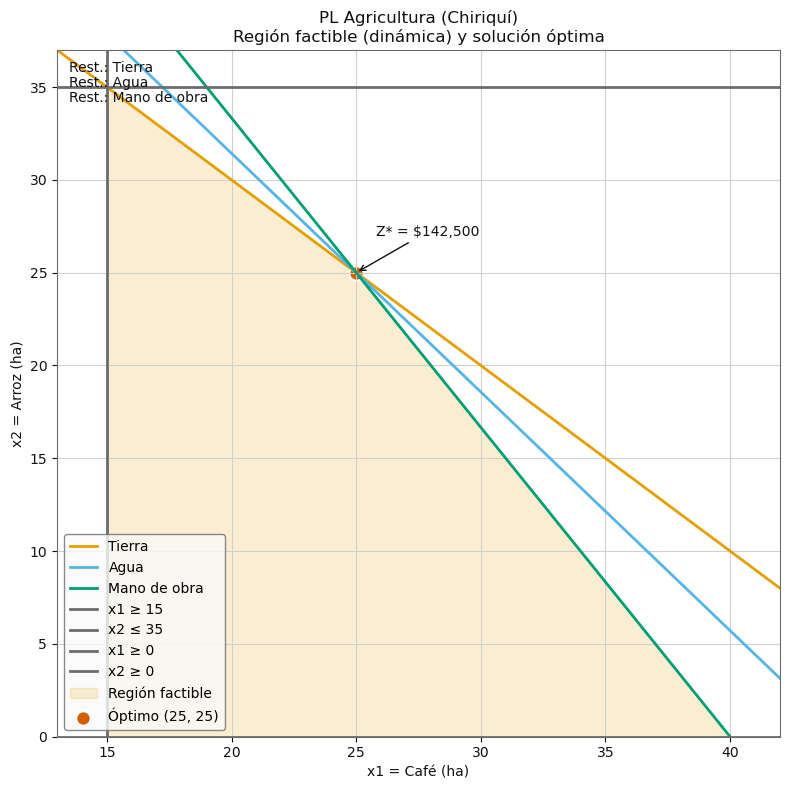

In [80]:
# -------------------------------------------------------
# Techne & Mind by harleeliz
# LP Agricultura (Chiriquí) — Modelo + Plot dinámico
# -------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from math import isfinite
from pulp import LpProblem, LpMaximize, LpVariable, value, LpStatusOptimal, LpStatus

# ---------- 0) Parámetros (Se pueden modificar valores) ----------
# Ganancias por ha (obj): [café, arroz]
OBJ = np.array([3500.0, 2200.0])

# Restricciones de recursos: a1*x1 + a2*x2 (sense) b
CONS = [
    {"a": np.array([1.0,   1.0]),   "sense": "<=", "b":  50.0, "label": "Tierra"},
    {"a": np.array([180.0, 140.0]), "sense": "<=", "b": 8000.0, "label": "Agua"},
    {"a": np.array([10.0,   6.0]),  "sense": "<=", "b":  400.0, "label": "Mano de obra"},
]

# Políticas / cotas de variables (índice 0=x1, 1=x2)
BOUNDS = [
    {"var": 0, "lb": 15.0, "label": "x1 ≥ 15 (mín. café)"},
    {"var": 1, "ub": 35.0, "label": "x2 ≤ 35 (máx. arroz)"},
    {"var": 0, "lb": 0.0,  "label": "x1 ≥ 0"},
    {"var": 1, "lb": 0.0,  "label": "x2 ≥ 0"},
]

# ---------- 1) Construcción del modelo PuLP ----------
# Derivamos lowBound/upBound de BOUNDS
lb = [0.0, 0.0]
ub = [None, None]
for bnd in BOUNDS:
    i = bnd["var"]
    if "lb" in bnd:
        lb[i] = max(lb[i], bnd["lb"])
    if "ub" in bnd:
        ub[i] = bnd["ub"] if ub[i] is None else min(ub[i], bnd["ub"])

prob = LpProblem("Agricultura_Chiriqui", LpMaximize)
x1 = LpVariable("Cafe_ha",  lowBound=lb[0], upBound=ub[0])
x2 = LpVariable("Arroz_ha", lowBound=lb[1], upBound=ub[1])

# Objetivo
prob += OBJ[0]*x1 + OBJ[1]*x2, "Ganancia_Total"

# Restricciones
for c in CONS:
    a1, a2, b = c["a"][0], c["a"][1], c["b"]
    if c["sense"] == "<=":
        prob += a1*x1 + a2*x2 <= b, c["label"]
    elif c["sense"] == ">=":
        prob += a1*x1 + a2*x2 >= b, c["label"]
    else:  # "=="
        prob += a1*x1 + a2*x2 == b, c["label"]

# Resolver
prob.solve()
status = LpStatus[prob.status]
print("Status:", status)

if prob.status != LpStatusOptimal:
    raise RuntimeError("Modelo no óptimo/inviable: revisa parámetros.")

x_star = np.array([float(value(x1)), float(value(x2))])
z_star  = float(OBJ @ x_star)
print(f"Café (x₁): {x_star[0]:.2f} ha")
print(f"Arroz (x₂): {x_star[1]:.2f} ha")
print(f"Ganancia (Z*): ${z_star:,.2f}")

# ---------- 2) Semiplanos (para el gráfico) ----------
# Convertimos todo a forma a·x <= b
H = []  # lista de (a,b,label)
for c in CONS:
    a = c["a"].astype(float).copy()
    b = float(c["b"])
    if c["sense"] == "<=":
        H.append((a, b, c["label"]))
    elif c["sense"] == ">=":
        H.append((-a, -b, c["label"]))  # -a·x <= -b
    else:  # "=="
        H.append(( a,  b, c["label"]+" (=)"))
        H.append((-a, -b, c["label"]+" (=)"))

# Cotas de variables como semiplanos
labels_bounds = []
for bnd in BOUNDS:
    i = bnd["var"]
    if "lb" in bnd:
        a = np.zeros(2); a[i] = -1.0   # -xi <= -lb
        H.append((a, -float(bnd["lb"]), bnd["label"]))
        labels_bounds.append(bnd["label"])
    if "ub" in bnd and bnd["ub"] is not None:
        a = np.zeros(2); a[i] =  1.0   #  xi <=  ub
        H.append((a,  float(bnd["ub"]), bnd["label"]))
        labels_bounds.append(bnd["label"])

# ---------- 3) Vértices del polígono factible ----------
def intersect(a1, b1, a2, b2, tol=1e-9):
    A = np.vstack([a1, a2])
    det = np.linalg.det(A)
    if abs(det) < tol:
        return None
    sol = np.linalg.solve(A, np.array([b1, b2]))
    if not (isfinite(sol[0]) and isfinite(sol[1])):
        return None
    return sol

def feasible(pt, H, tol=1e-7):
    return all(a @ pt <= b + tol for (a,b,_) in H)

# Intersección de todas las parejas de rectas a·x = b
V = []
for i in range(len(H)):
    for j in range(i+1, len(H)):
        p = intersect(H[i][0], H[i][1], H[j][0], H[j][1])
        if p is None: 
            continue
        if feasible(p, H):
            V.append(p)

if not V:
    raise RuntimeError("No se encontró polígono factible (¿inviable?).")

# Quitamos duplicados y ordenamos en sentido antihorario
V = np.unique(np.round(np.array(V), 8), axis=0)
ctr = V.mean(axis=0)
angles = np.arctan2(V[:,1]-ctr[1], V[:,0]-ctr[0])
order = np.argsort(angles)
V = V[order]

# ---------- 4) Restricciones activas en el óptimo ----------
def is_active(a,b,pt,tol=1e-6):
    return abs(a @ pt - b) <= tol

active_labels = [lab for (a,b,lab) in H if is_active(a,b,x_star)]

# ---------- 5) Plot (1080×1080, paleta color-blind friendly) ----------
PAL = {
    "tierra": "#E69F00",    # orange
    "agua":   "#56B4E9",    # sky blue
    "mano":   "#009E73",    # green
    "bounds": "#6A6D70",    # medium gray
    "fill":   "#E69F00",    # fill (con alpha)
    "opt":    "#D55E00",    # red/orange for optimal point
    "grid":   "#D0D0D0",
    "text":   "#111111",
    "bg":     "#FFFFFF",
    "panel":  "#FFFFFF",
}
WIDTH_PX, HEIGHT_PX, DPI = 800, 800, 100
plt.figure(figsize=(WIDTH_PX/DPI, HEIGHT_PX/DPI), dpi=DPI)
ax = plt.gca(); plt.gcf().patch.set_facecolor(PAL["bg"]); ax.set_facecolor(PAL["panel"])

# Rango de ejes a partir del polígono
xmin, ymin = V.min(axis=0) - 2
xmax, ymax = V.max(axis=0) + 2
xmin, ymin = max(0, xmin), max(0, ymin)  # no-negatividad visual

# Dibuja cada recta a·x = b
xs = np.linspace(xmin, xmax, 600)
def plot_line(a, b, label, color, lw=2.0, ls="-"):
    # a1*x + a2*y = b -> y = (b - a1*x)/a2 (si a2 != 0), sino recta vertical
    if abs(a[1]) > 1e-12:
        ys = (b - a[0]*xs) / a[1]
        plt.plot(xs, ys, color=color, linewidth=lw, linestyle=ls, label=label)
    else:
        x = b / a[0]
        plt.plot([x, x], [ymin, ymax], color=color, linewidth=lw, linestyle=ls, label=label)

# Mapeo de color por etiqueta “conocida”
color_map = {"Tierra": PAL["tierra"], "Agua": PAL["agua"], "Mano": PAL["mano"], "Mano de obra": PAL["mano"]}

# Dibuja líneas (una vez por etiqueta base)
drawn = set()
for (a,b,label) in H:
    base = label.split(" (")[0]  # quita paréntesis para agrupar
    if base in drawn:
        continue
    color = color_map.get(base, PAL["bounds"])
    plot_line(a, b, base, color)
    drawn.add(base)

# Borde y relleno del polígono factible
plt.fill(V[:,0], V[:,1], color=PAL["fill"], alpha=0.18, label="Región factible")

# Punto óptimo
plt.scatter([x_star[0]], [x_star[1]], s=110, marker="o",
            facecolor=PAL["opt"], edgecolor="white", linewidth=1.6,
            label=f"Óptimo ({x_star[0]:.0f}, {x_star[1]:.0f})")
plt.annotate(f"Z* = ${z_star:,.0f}",
             (x_star[0], x_star[1]), xytext=(x_star[0]+0.8, x_star[1]+2.0),
             color=PAL["text"], arrowprops=dict(arrowstyle='->', color=PAL["text"]))

# Marcar restricciones activas
for lab in active_labels:
    plt.text(xmin+0.5, ymax-1.2 - 0.8*active_labels.index(lab), f"Rest.: {lab}", color=PAL["text"])

# Estética
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.xlabel("x1 = Café (ha)", color=PAL["text"])
plt.ylabel("x2 = Arroz (ha)", color=PAL["text"])
plt.title("PL Agricultura (Chiriquí)\nRegión factible (dinámica) y solución óptima", color=PAL["text"])
plt.grid(True, color=PAL["grid"])
ax.tick_params(colors=PAL["text"])
for s in ax.spines.values():
    s.set_color(PAL["bounds"])
leg = plt.legend(loc="lower left", frameon=True)
leg.get_frame().set_edgecolor(PAL["bounds"])
leg.get_frame().set_facecolor("#FAFAFA")
plt.tight_layout()
plt.show()


**En el gráfico**:
- Eje X: x₁ (café), 0-50
- Eje Y: x₂ (arroz), 0-50
- Líneas de restricción en diferentes colores
- Región factible sombreada
- Vértices marcados con círculos
- Punto óptimo destacado en color rojo
- 2-3 líneas iso-ganancia para mostrar dirección de mejora

### Vértices a Evaluar

| Punto | Coordenadas | Z = 3,500x₁ + 2,200x₂ | ¿Óptimo? |
|-------|-------------|----------------------|----------|
| A | (15, 0) | $52,500 | No |
| B | (15, 35) | $129,500 | No |
| **C** | **(25, 25)** | **$142,500** | Si |
| D | (40, 0) | $140,000 | No |

### ¿Por Qué (25, 25) es Óptimo?

Es el punto donde se intersectan **tres restricciones activas**:
- Tierra: 25 + 25 = 50 ✓
- Agua: 180(25) + 140(25) = 8,000 ✓
- Mano de obra: 10(25) + 6(25) = 400 ✓

**Los recursos se usan al 100%** → máxima eficiencia





### Uso de Recursos 

| Recurso | Usado | Disponible | Holgura | Estado |
|---------|-------|------------|---------|---------|
| Tierra | 50 | 50 | 0 |  **Saturado** |
|  Agua | 8,000 | 8,000 | 0 |  **Saturado** |
|  Mano obra | 400 | 400 | 0 |  **Saturado** |
|  Café mín | 25 | ≥15 | +10 |  **Holgado** |
|  Arroz máx | 25 | ≤35 | +10 |  **Holgado** |

### Precios Sombra (Shadow Prices)

**¿Cuánto vale 1 unidad adicional de cada recurso?**

| Recurso | Precio Sombra | Interpretación |
|---------|--------------|----------------|
| Tierra | $250/ha | Por cada ha extra, ganancia sube $250 |
| Agua | $3.13/m³ | Por cada m³ extra, ganancia sube $3.13 |
|  Mano obra | $325/día | Por cada día extra, ganancia sube $325 |

> **Insight**: La mano de obra es el recurso más valioso. 
> Invertir en contratar más personal tendría el mayor ROI.

### Rango de Estabilidad del Precio del Café

El plan actual (25, 25) sigue siendo óptimo si el precio 
del café oscila entre:

```
$2,828.57/ha ≤ c₁ ≤ $3,666.67/ha
```

Fuera de ese rango, convendría cambiar la mezcla de cultivos.


### Hallazgos Estratégicos

1. **Cuello de botella triple**
   - Los 3 recursos principales están al 100%
   - Cualquier mejora requiere aumentar tierra, agua Y mano de obra

2. **Prioridades de inversión**
   - Mano de obra ($325/día)
   - Tierra ($250/ha)
   - Agua ($3.13/m³)

3. **Flexibilidad de precio**
   - El café puede variar ±20% sin cambiar el plan
   - Diversificación (50-50) es robusta ante fluctuaciones

4. **Margen de maniobra**
   - Hay 10 ha de "colchón" en ambos cultivos
   - No estamos forzados por los límites de café/arroz

### Aplicaciones del Modelo

-Reasignar cultivos ante cambios de precio  
-Evaluar expansión de recursos (ROI)  
-Negociar contratos con datos duros  
-Planificación estacional con PL multi-período

---
## Newsletter Techne&Mind Datos a Decisiones & Contacto

¿Preguntas? ¿Ideas para optimizar tu negocio?

- LinkedIn:   https://www.linkedin.com/in/harlee-ramos/
- Email: harleeliz6@gmx.com
- GitHub: @harleeliz